# Imports

In [ ]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import json
import torchvision.transforms.functional as TF
from PIL import Image, ImageDraw, ImageFilter, ImageEnhance
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models import (resnet18, ResNet18_Weights, resnet50, ResNet50_Weights, resnet152, ResNet152_Weights,
                              efficientnet_b0, EfficientNet_B0_Weights,
                              vgg16, VGG16_Weights)
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)
from sklearn.model_selection import train_test_split
import time
import random
import copy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)
#torch.cuda.manual_seed_all(RANDOM_SEED)

# Configs

In [ ]:
TRAIN_IMGS_PATH = '/content/drive/MyDrive/GBCUD/dataset/train'
TEST_IMGS_PATH = '/content/drive/MyDrive/GBCUD/dataset/test'
SAVE_MODEL_DIR = '/content/drive/MyDrive/GBCUD/'

In [ ]:
RANDOM_SEED = 42
LABEL_MAPPING = {'0_normal': 0, '1_benign': 1, '2_malignant': 2}
CLASS_NAMES = list(LABEL_MAPPING.keys())

LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-5
BATCH_SIZE = 1      # 1 bag
NUM_EPOCHS = 50
PATIENCE = 10
BAG_SIZE = 10       # number of instances per bag
NUM_CLASSES = len(LABEL_MAPPING)
CLASS_WEIGHTS = [0.8, 0.6, 3.0] # Example weights

FEATURE_DIM_L = 512
ATTENTION_DIM_D = 256
ATTENTION_HEADS_K = 1
DROPOUT_RATE = 0.5

IMG_RESIZE = (256, 256) # Initial resize size
IMG_CROP_SIZE = (224, 224) # Final input size to model

# Define normalization constants
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Helper functions

In [ ]:
#plots training and validation loss and accuracy graphs
def plot_training_history(train_losses, train_acc, val_losses, val_acc):
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(15, 5))

    # accuracy graph
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Model Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # loss graph
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.title('Model Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

#compute and plot the confusion matrix
def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix (Test Data)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Preprocessing and Data augmentation

In [ ]:
 # applies transforms to the entire image before patching
def get_train_transforms(resize_dim=IMG_RESIZE, crop_dim=IMG_CROP_SIZE):
  def crop_top_half(image, **kwargs):
      h, w = image.shape[:2]
      y_min = int(0.20 * h)
      y_max = int(0.90 * h)
      return image[y_min:y_max, :]

  return A.Compose([
      A.Resize(height=resize_dim[0], width=resize_dim[1]),
      A.Rotate(limit=10, p=0.5, border_mode=cv2.BORDER_CONSTANT, fill=0),
      A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),
      A.ISONoise(intensity=(0.1, 0.4), p=0.3),
      # A.RandomShadow(p=0.3),
      A.Lambda(image=crop_top_half),
      # A.CenterCrop(height=crop_dim[0], width=crop_dim[1]),
      A.HorizontalFlip(p=0.5),
      A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
      ToTensorV2()
  ])

def get_eval_transforms(img_dim=IMG_CROP_SIZE):
    return A.Compose([
        A.Resize(height=img_dim[0], width=img_dim[1]),
        A.CenterCrop(height=img_dim[0], width=img_dim[1]),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ToTensorV2()
    ])

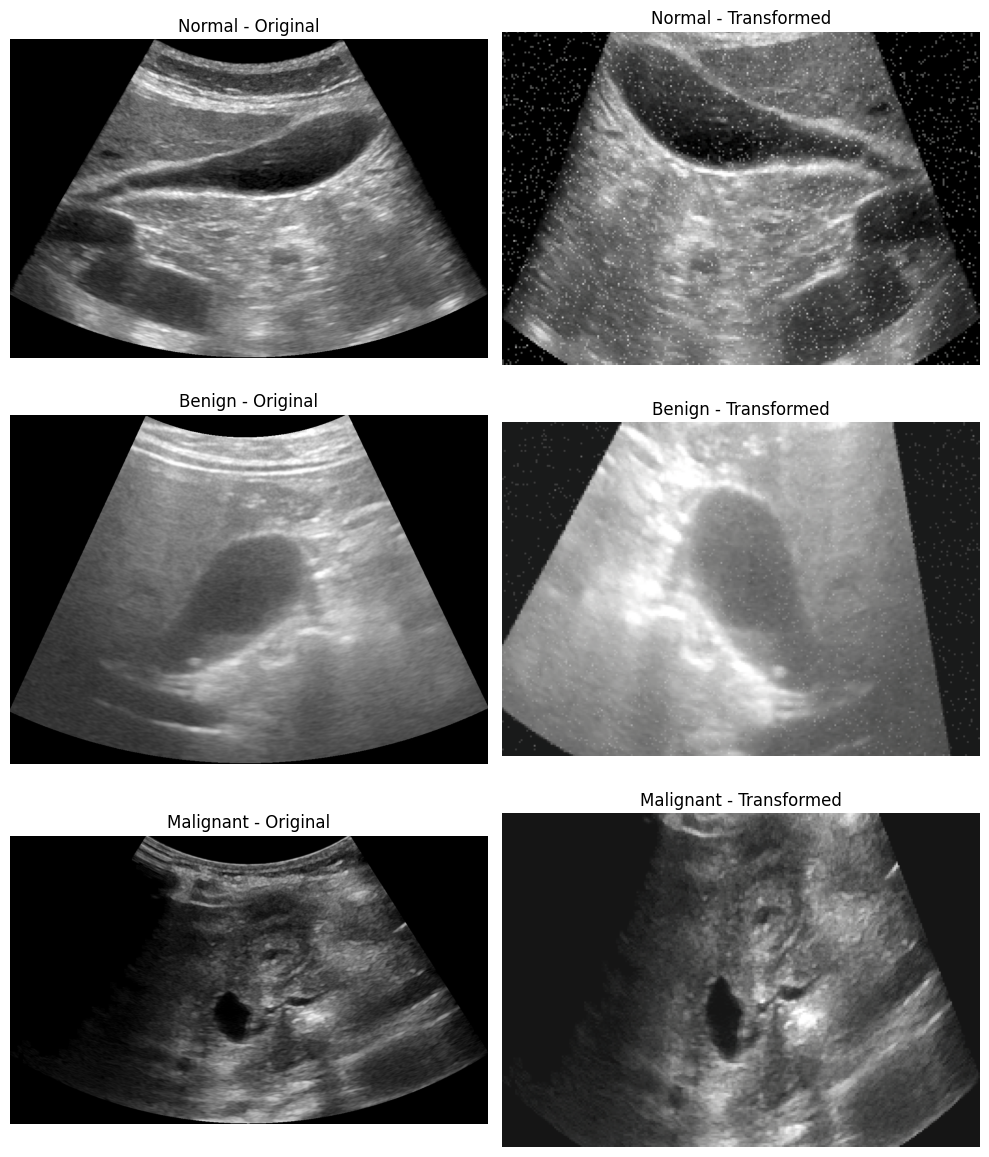

In [ ]:
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torchvision.transforms.functional import to_pil_image
import numpy as np


# Load and transform image
def visualize_transformed_image(image_path, transform):
    original_img = cv2.imread(image_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    transformed = transform(image=original_img)
    transformed_img = transformed["image"]

    # De-normalize for visualization
    img_vis = transformed_img.clone()
    img_vis = img_vis * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img_vis = img_vis + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img_vis = torch.clamp(img_vis, 0, 1)

    return original_img, to_pil_image(img_vis)

# Example usage:
sample_paths = {
    "Normal": "/content/drive/MyDrive/GBCUD/dataset/train/0_normal/im00007.jpg",
    "Benign": "/content/drive/MyDrive/GBCUD/dataset/train/1_benign/im00001.jpg",
    "Malignant": "/content/drive/MyDrive/GBCUD/dataset/train/2_malignant/im00017.jpg"
}

transform = get_train_transforms()

fig, axes = plt.subplots(3, 2, figsize=(10, 12))

for idx, (label, img_path) in enumerate(sample_paths.items()):
    original, transformed = visualize_transformed_image(img_path, transform)

    axes[idx, 0].imshow(original)
    axes[idx, 0].set_title(f"{label} - Original")
    axes[idx, 0].axis("off")

    axes[idx, 1].imshow(transformed)
    axes[idx, 1].set_title(f"{label} - Transformed")
    axes[idx, 1].axis("off")

plt.tight_layout()
plt.show()


# Dataset

In [ ]:
class ImageBagDataset(Dataset):
    def __init__(self, image_dir, transform=None, bag_size=10, balance_classes=False):
        """
        Args:
            image_dir (str): Root directory with subfolders for each class.
            transform (callable): Transformation to apply to each image.
            bag_size (int): Number of whole images per bag.
        """
        self.samples = datasets.ImageFolder(root=image_dir).samples
        self.bag_size = bag_size
        self.transform = transform

        # Step 1: Group indices by class
        self.label_to_indices = {}
        for idx, (_, label) in enumerate(self.samples):
            self.label_to_indices.setdefault(label, []).append(idx)

        # Step 2: Create class-wise bags
        class_to_bags = {}
        for label, indices in self.label_to_indices.items():
            np.random.shuffle(indices)
            bags = []
            for i in range(0, len(indices) - bag_size + 1, bag_size):
                bag_indices = indices[i:i + bag_size]
                bags.append((bag_indices, label))
            class_to_bags[label] = bags

        # Step 3: Optionally balance the bags
        if balance_classes:
            max_count = max(len(bags) for bags in class_to_bags.values())
            balanced_bags = []
            for label, bags in class_to_bags.items():
                repeat_factor = max_count // len(bags)
                extras_needed = max_count - (repeat_factor * len(bags))
                balanced_bags.extend(bags * repeat_factor + bags[:extras_needed])
            self.bags = balanced_bags
        else:
            # Flatten all bags into a list
            self.bags = [bag for bags in class_to_bags.values() for bag in bags]

        # Shuffle and finalize
        np.random.shuffle(self.bags)
        self.targets = np.array([label for (_, label) in self.bags])

    def __len__(self):
        return len(self.bags)

    def __getitem__(self, idx):
        bag_indices, label = self.bags[idx]
        bag_images = []

        for i in bag_indices:
            img_path, _ = self.samples[i]
            image = np.array(Image.open(img_path).convert("RGB"))

            if self.transform:
                image = self.transform(image=image)["image"]

            bag_images.append(image)

        bag_tensor = torch.stack(bag_images)  # Shape: [bag_size, C, H, W]
        return bag_tensor, label

    # def __getitem__(self, idx):
    #     bag_indices, label = self.bags[idx]
    #     bag_images = [self.dataset[i][0] for i in bag_indices]
    #     bag_tensor = torch.stack(bag_images)
    #     return bag_tensor, label

# Model build

In [ ]:
class AttentionMILModel(nn.Module):
    def __init__(self, num_classes=3, backbone_name='resnet18', pretrained=True,
                 feature_dim=512, attention_dim=128, attention_heads=1, dropout=0.25):
        super().__init__()
        self.L = feature_dim
        self.D = attention_dim
        self.K = attention_heads
        self.num_classes = num_classes

        # Backbone feature extractor
        self.feature_extractor, backbone_out_dim = self._get_backbone(backbone_name, pretrained)

        # Adaptive pooling and feature embedding
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.feature_embedder = nn.Sequential(
            nn.Linear(backbone_out_dim, self.L),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(self.L, self.L),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Vanilla Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )

        # Classifier
        self.classifier = nn.Linear(self.L * self.K, self.num_classes)

    def _get_backbone(self, name, pretrained):
        weights = 'DEFAULT' if pretrained else None

        if name == "resnet18":
            model = resnet18(weights=weights)
            return nn.Sequential(*list(model.children())[:-2]), 512
        elif name == "resnet50":
            model = resnet50(weights=weights)
            return nn.Sequential(*list(model.children())[:-2]), 2048
        elif name == "resnet152":
            model = resnet152(weights=weights)
            return nn.Sequential(*list(model.children())[:-2]), 2048
        elif name == "efficientnet_b0":
            model = efficientnet_b0(weights=weights)
            return model.features, 1280
        elif name == "vgg16":
            model = vgg16(weights=weights)
            return nn.Sequential(*list(model.features.children())[:-1]), 512
        else:
            raise ValueError(f"Unsupported backbone: {name}")

    def forward(self, x):
        N, C, H, W = x.shape
        B = 1
        x = x.view(B * N, C, H, W)

        features = self.feature_extractor(x)
        features = self.pool(features).view(B * N, -1)
        embedded = self.feature_embedder(features)  # (B*N, L)

        A = self.attention(embedded)               # (B*N, K)
        A = A.view(B, N, self.K)
        A = F.softmax(A, dim=1)                    # softmax over instances

        A = A.transpose(1, 2)                      # (B, K, N)
        embedded = embedded.view(B, N, self.L)     # (B, N, L)
        M = torch.bmm(A, embedded)                 # (B, K, L)

        M = M.view(B, -1)
        logits = self.classifier(M)                # (B, num_classes)
        probs = F.softmax(logits, dim=1)

        return logits, probs, A.transpose(1, 2)

    def calculate_objective(self, x_batch, y_batch, criterion):
        logits, _, _ = self.forward(x_batch)
        return criterion(logits, y_batch)

    def calculate_prediction_accuracy(self, x_batch, y_batch):
        logits, _, _ = self.forward(x_batch)
        preds = torch.argmax(logits, dim=1)
        correct = preds.eq(y_batch).sum().item()
        total = y_batch.size(0)
        return preds, correct / total, correct, total

    def get_attention_map(self, bag_tensor):
        self.eval()
        with torch.no_grad():
            if bag_tensor.ndim != 4:
                raise ValueError(f"Expected input of shape (bag_size, 3, H, W), got {bag_tensor.shape}")

            N, C, H, W = bag_tensor.shape
            device = next(self.parameters()).device
            bag_tensor = bag_tensor.to(device)

            features = self.feature_extractor(bag_tensor)
            features = self.pool(features).view(N, -1)
            embedded = self.feature_embedder(features)

            A_scores = self.attention(embedded)      # (N, K)
            A_weights = F.softmax(A_scores, dim=0)   # softmax over instances
            attention = A_weights[:, 0].cpu().numpy()

            return attention


In [ ]:
#vanilla attention
model = AttentionMILModel(num_classes=3, backbone_name='resnet18')
print(model)

AttentionMILModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
dummy_input = torch.randn(10, 3, 224, 224)
logits, probs, att = model(dummy_input)
print(model)

AttentionMILModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

# Train and Evaluate

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs, device, save_dir, model_name, patience=PATIENCE):
  os.makedirs(save_dir, exist_ok=True)

  best_val_loss = float('inf')
  best_model_wts = None
  epochs_no_improve = 0
  history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}


  model.to(device)
  print(f"Training started...")

  for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for bags, labels in train_loader:
      bags = bags.squeeze(0).to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      logits, probs, _ = model(bags)
      loss = criterion(logits, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item() * bags.size(0) # Weighted by batch size
      preds = torch.argmax(probs, dim=1)
      train_correct += (preds == labels).sum().item()
      train_total += labels.size(0)

    epoch_train_loss = running_loss / train_total
    epoch_train_acc = train_correct / train_total
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)

    # validation
    val_metrics, _, _ = evaluate_model(model, val_loader, criterion, device)
    epoch_val_loss = val_metrics['loss']
    epoch_val_acc = val_metrics['accuracy']
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}")

    # early stopping
    if epoch_val_loss < best_val_loss:
      best_val_loss = epoch_val_loss
      epochs_no_improve = 0
      save_path = os.path.join(save_dir, model_name)
      torch.save(model.state_dict(), save_path)
      print(f"Validation loss improved. Model saved to {save_path}")
    else:
      epochs_no_improve += 1
      print(f"Validation loss did not improve for {epochs_no_improve} epochs.")
      if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1} after {patience} epochs without improvement.")
        break

  print("\nTraining finished.")

  model.load_state_dict(torch.load(save_path))
  print("Loaded best model weights.")

  return model, history

In [ ]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for bags, labels in dataloader:
            bags = bags.squeeze(0).to(device)
            labels = labels.to(device)

            logits, probs, _ = model(bags)
            loss = criterion(logits, labels)
            total_loss += loss.item() * bags.size(0) # Multiply by batch size (num bags)

            preds = torch.argmax(probs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples

    # Calculate other metrics using sklearn
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    metrics = {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    return metrics, all_labels, all_preds

# Experiments

In [ ]:
from collections import Counter
print("Bag distribution:", Counter(full_train_dataset.targets))

Bag distribution: Counter({np.int64(1): 50, np.int64(0): 40, np.int64(2): 22})


In [ ]:
BACKBONE_NAME = "resnet18"
PRETRAINED = "true"

Using device: cuda
Images per bag: 10
Load the datasets...
Full Train dataset: 150 bags found.
Test dataset: 11 bags found.
Splitting train data
Training subset size: 120
Validation subset size: 30
Creating DataLoaders...
Setting up model with resnet18 backbone
Using CrossEntropyLoss with weights: [0.8, 0.6, 3.0]
Training started...
Epoch 1/50 | Train Loss: 11.0150, Acc: 0.3583 | Val Loss: 10.9861, Acc: 0.3333
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/gam_model2.pth
Epoch 2/50 | Train Loss: 10.9826, Acc: 0.3083 | Val Loss: 10.9988, Acc: 0.3333
Validation loss did not improve for 1 epochs.
Epoch 3/50 | Train Loss: 10.9524, Acc: 0.4000 | Val Loss: 10.9890, Acc: 0.3667
Validation loss did not improve for 2 epochs.
Epoch 4/50 | Train Loss: 10.9981, Acc: 0.3250 | Val Loss: 10.9896, Acc: 0.3000
Validation loss did not improve for 3 epochs.
Epoch 5/50 | Train Loss: 11.0134, Acc: 0.3333 | Val Loss: 11.0251, Acc: 0.3333
Validation loss did not improve for 4 epochs.
E

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


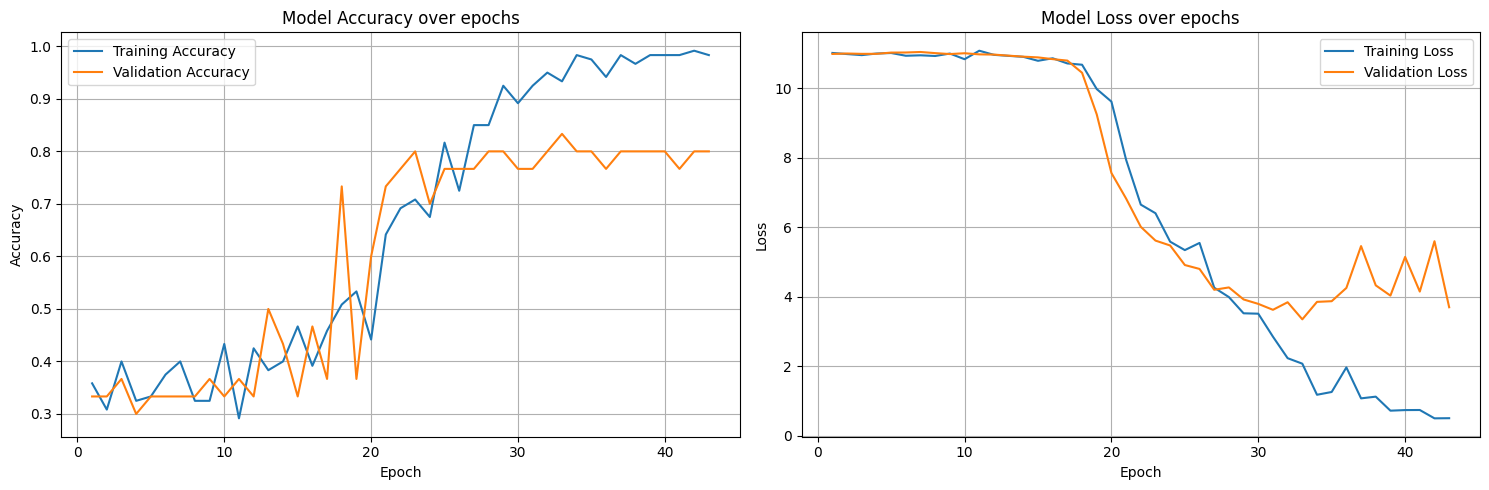

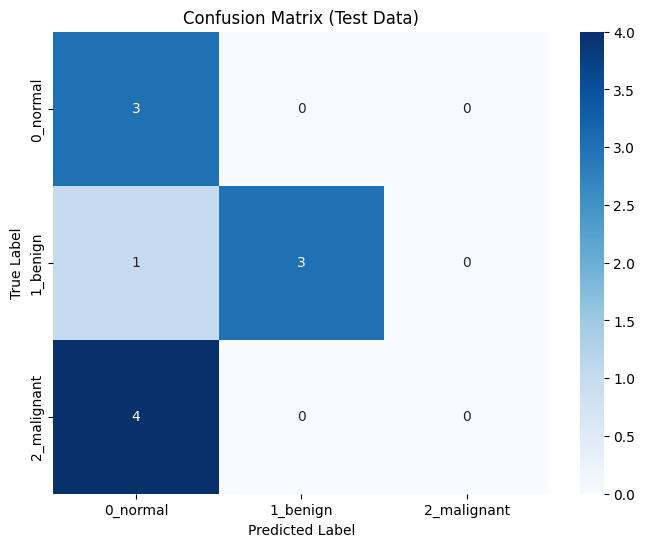


DONEEEEE.


In [ ]:
if __name__ == "__main__":
    print(f"Using device: {device}")
    print(f"Images per bag: {BAG_SIZE}")

    train_transforms = get_train_transforms(resize_dim=IMG_RESIZE, crop_dim=IMG_CROP_SIZE)
    eval_transforms = get_eval_transforms(img_dim=IMG_CROP_SIZE) # Use final crop size

    print("Load the datasets...")

    full_train_dataset = ImageBagDataset(
    image_dir=TRAIN_IMGS_PATH,
    transform=train_transforms,
    bag_size=BAG_SIZE,
    balance_classes=True
    )

    test_dataset = ImageBagDataset(
    image_dir=TEST_IMGS_PATH,
    transform=eval_transforms,
    bag_size=BAG_SIZE
    )

    print(f"Full Train dataset: {len(full_train_dataset)} bags found.")
    print(f"Test dataset: {len(test_dataset)} bags found.")

    # Train/Validation Split
    print("Splitting train data")
    targets = full_train_dataset.targets

    train_idx, val_idx = train_test_split(
        np.arange(len(targets)),
        test_size=0.2, # 20% for validation
        stratify=targets,
        random_state=RANDOM_SEED
    )

    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Weighted sampler for the training subset
    train_targets = np.array(targets)[train_idx]
    class_counts = np.bincount(train_targets, minlength=NUM_CLASSES)

    weights = 1.0 / class_counts #what if a class has no samples in the split

    sample_weights = np.array([weights[label] for label in train_targets])
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    print(f"Training subset size: {len(train_subset)}")
    print(f"Validation subset size: {len(val_subset)}")


    print("Creating DataLoaders...")
    num_workers = 2              # If there's issues set num_workers=0

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

    # creating model instance
    print(f"Setting up model with {BACKBONE_NAME} backbone")
    model = AttentionMILModel(num_classes=NUM_CLASSES, backbone_name=BACKBONE_NAME,
                      pretrained=PRETRAINED, feature_dim=FEATURE_DIM_L,
                      attention_dim=ATTENTION_DIM_D, attention_heads=ATTENTION_HEADS_K,
                      dropout=DROPOUT_RATE).to(device)


    class_weights_tensor = torch.tensor(CLASS_WEIGHTS, device=device, dtype=torch.float)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print(f"Using CrossEntropyLoss with weights: {CLASS_WEIGHTS}")


    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1) # Example scheduler

    # train model
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=device,
        save_dir=SAVE_MODEL_DIR,
        model_name='gam_model2.pth',
        patience=PATIENCE
        # Pass scheduler if using one
    )

    # Final Evaluation on Test Set
    print("\nEvaluating on Test Set")
    trained_model.to(device)
    test_metrics, all_labels, all_preds = evaluate_model(trained_model, test_loader, criterion, device)

    print("\nTest Set Evaluation Metrics")
    print(f"Test Loss: {test_metrics['loss']:.4f}")
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test Precision (Macro): {test_metrics['precision']:.4f}")
    print(f"Test Recall (Macro): {test_metrics['recall']:.4f}")
    print(f"Test F1 Score (Macro): {test_metrics['f1']:.4f}")
    print("")

    print("\nEvaluation per class")
    print(classification_report(all_labels, all_preds, target_names=["Normal", "Benign", "Malignant"]))


    # --- Plotting ---
    print("\nPlotting results")
    plot_training_history(history['train_loss'], history['train_acc'],
                          history['val_loss'], history['val_acc'])

    #Confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names=CLASS_NAMES)

    print("\nDONEEEEE.")

In [ ]:
BACKBONE_NAME = "resnet50"
PRETRAINED = "true"

Using device: cuda
Images per bag: 10
Load the datasets...
Full Train dataset: 150 bags found.
Test dataset: 11 bags found.
Splitting train data
Training subset size: 120
Validation subset size: 30
Creating DataLoaders...
Setting up model with resnet50 backbone
Using CrossEntropyLoss with weights: [0.8, 0.6, 3.0]
Training started...
Epoch 1/50 | Train Loss: 10.9752, Acc: 0.3333 | Val Loss: 10.9836, Acc: 0.3000
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/gam_model2.pth
Epoch 2/50 | Train Loss: 10.9928, Acc: 0.3083 | Val Loss: 10.9760, Acc: 0.3333
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/gam_model2.pth
Epoch 3/50 | Train Loss: 10.9562, Acc: 0.3750 | Val Loss: 10.9739, Acc: 0.3333
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/gam_model2.pth
Epoch 4/50 | Train Loss: 10.9675, Acc: 0.3500 | Val Loss: 10.9711, Acc: 0.3333
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/gam_model2.pth
Epoch 5/5

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


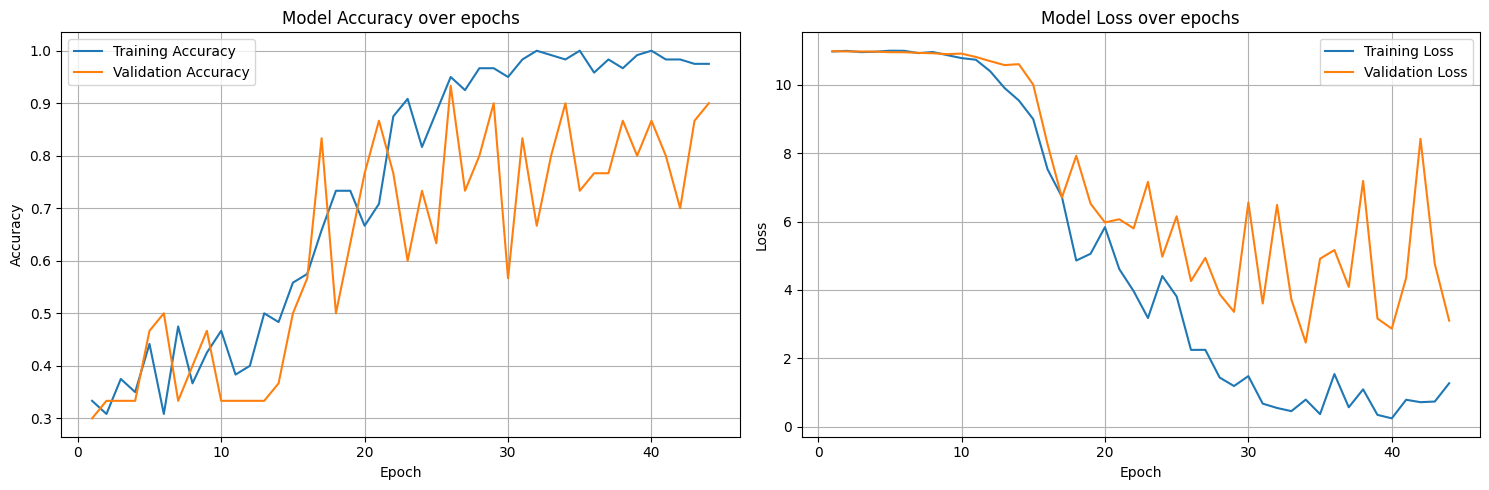

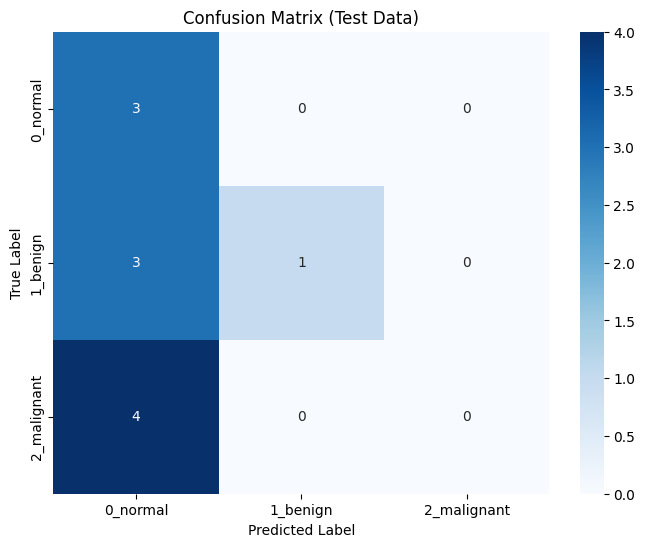


DONEEEEE.


In [ ]:
if __name__ == "__main__":
    print(f"Using device: {device}")
    print(f"Images per bag: {BAG_SIZE}")

    train_transforms = get_train_transforms(resize_dim=IMG_RESIZE, crop_dim=IMG_CROP_SIZE)
    eval_transforms = get_eval_transforms(img_dim=IMG_CROP_SIZE) # Use final crop size

    print("Load the datasets...")

    full_train_dataset = ImageBagDataset(
    image_dir=TRAIN_IMGS_PATH,
    transform=train_transforms,
    bag_size=BAG_SIZE,
    balance_classes=True
    )

    test_dataset = ImageBagDataset(
    image_dir=TEST_IMGS_PATH,
    transform=eval_transforms,
    bag_size=BAG_SIZE
    )

    print(f"Full Train dataset: {len(full_train_dataset)} bags found.")
    print(f"Test dataset: {len(test_dataset)} bags found.")

    # Train/Validation Split
    print("Splitting train data")
    targets = full_train_dataset.targets

    train_idx, val_idx = train_test_split(
        np.arange(len(targets)),
        test_size=0.2, # 20% for validation
        stratify=targets,
        random_state=RANDOM_SEED
    )

    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Weighted sampler for the training subset
    train_targets = np.array(targets)[train_idx]
    class_counts = np.bincount(train_targets, minlength=NUM_CLASSES)

    weights = 1.0 / class_counts #what if a class has no samples in the split

    sample_weights = np.array([weights[label] for label in train_targets])
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    print(f"Training subset size: {len(train_subset)}")
    print(f"Validation subset size: {len(val_subset)}")


    print("Creating DataLoaders...")
    num_workers = 2              # If there's issues set num_workers=0

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

    # creating model instance
    print(f"Setting up model with {BACKBONE_NAME} backbone")
    model = AttentionMILModel(num_classes=NUM_CLASSES, backbone_name=BACKBONE_NAME,
                      pretrained=PRETRAINED, feature_dim=FEATURE_DIM_L,
                      attention_dim=ATTENTION_DIM_D, attention_heads=ATTENTION_HEADS_K,
                      dropout=DROPOUT_RATE).to(device)


    class_weights_tensor = torch.tensor(CLASS_WEIGHTS, device=device, dtype=torch.float)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print(f"Using CrossEntropyLoss with weights: {CLASS_WEIGHTS}")


    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1) # Example scheduler

    # train model
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=device,
        save_dir=SAVE_MODEL_DIR,
        model_name='gam_model2.pth',
        patience=PATIENCE
        # Pass scheduler if using one
    )

    # Final Evaluation on Test Set
    print("\nEvaluating on Test Set")
    trained_model.to(device)
    test_metrics, all_labels, all_preds = evaluate_model(trained_model, test_loader, criterion, device)

    print("\nTest Set Evaluation Metrics")
    print(f"Test Loss: {test_metrics['loss']:.4f}")
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test Precision (Macro): {test_metrics['precision']:.4f}")
    print(f"Test Recall (Macro): {test_metrics['recall']:.4f}")
    print(f"Test F1 Score (Macro): {test_metrics['f1']:.4f}")
    print("")

    print("\nEvaluation per class")
    print(classification_report(all_labels, all_preds, target_names=["Normal", "Benign", "Malignant"]))


    # --- Plotting ---
    print("\nPlotting results")
    plot_training_history(history['train_loss'], history['train_acc'],
                          history['val_loss'], history['val_acc'])

    #Confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names=CLASS_NAMES)

    print("\nDONEEEEE.")

In [ ]:
BACKBONE_NAME = "resnet152"
PRETRAINED = "true"

Using device: cuda
Images per bag: 10
Load the datasets...
Full Train dataset: 150 bags found.
Test dataset: 11 bags found.
Splitting train data
Training subset size: 120
Validation subset size: 30
Creating DataLoaders...
Setting up model with resnet152 backbone


Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 205MB/s]


Using CrossEntropyLoss with weights: [0.8, 0.6, 3.0]
Training started...
Epoch 1/50 | Train Loss: 11.0189, Acc: 0.3250 | Val Loss: 10.9669, Acc: 0.3333
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/vam_model2.pth
Epoch 2/50 | Train Loss: 10.9564, Acc: 0.4000 | Val Loss: 10.9633, Acc: 0.3333
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/vam_model2.pth
Epoch 3/50 | Train Loss: 10.9966, Acc: 0.3333 | Val Loss: 10.9466, Acc: 0.5000
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/vam_model2.pth
Epoch 4/50 | Train Loss: 10.9587, Acc: 0.4000 | Val Loss: 10.9349, Acc: 0.3333
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/vam_model2.pth
Epoch 5/50 | Train Loss: 10.9434, Acc: 0.3833 | Val Loss: 10.8780, Acc: 0.5667
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/vam_model2.pth
Epoch 6/50 | Train Loss: 10.9504, Acc: 0.3333 | Val Loss: 10.8363, Acc: 0.5667
Validation loss improved. Mo

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


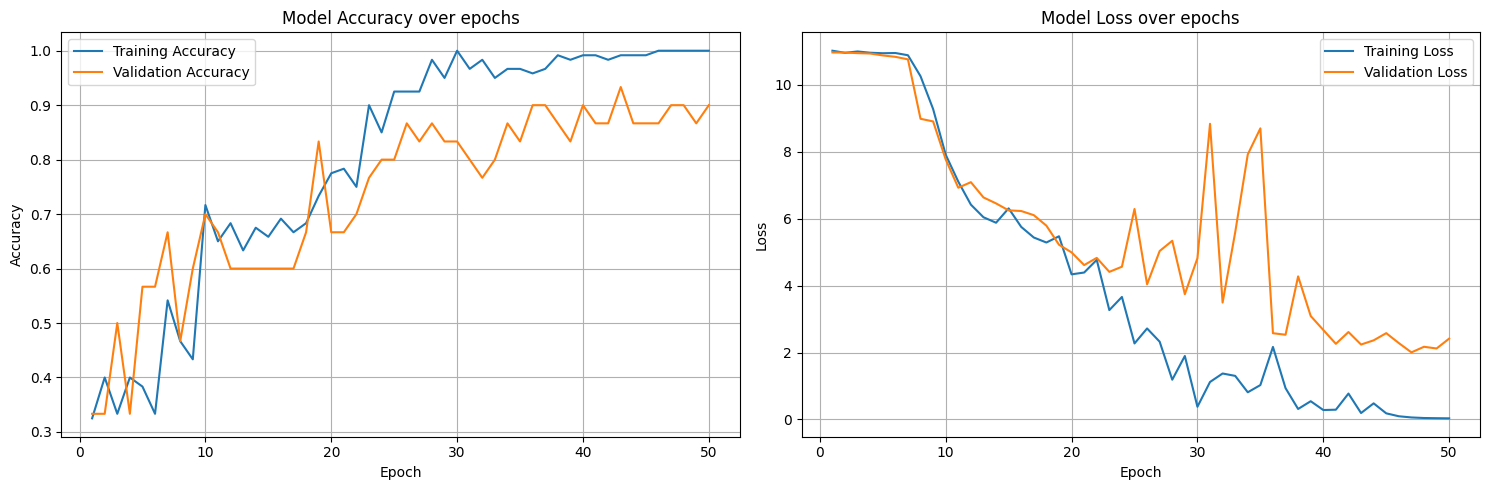

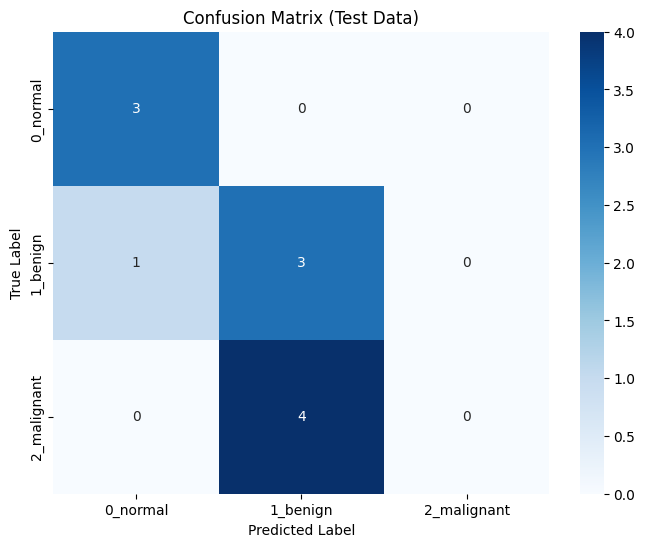


DONEEEEE.


In [ ]:
if __name__ == "__main__":
    print(f"Using device: {device}")
    print(f"Images per bag: {BAG_SIZE}")

    train_transforms = get_train_transforms(resize_dim=IMG_RESIZE, crop_dim=IMG_CROP_SIZE)
    eval_transforms = get_eval_transforms(img_dim=IMG_CROP_SIZE) # Use final crop size

    print("Load the datasets...")

    full_train_dataset = ImageBagDataset(
    image_dir=TRAIN_IMGS_PATH,
    transform=train_transforms,
    bag_size=BAG_SIZE,
    balance_classes=True
    )

    test_dataset = ImageBagDataset(
    image_dir=TEST_IMGS_PATH,
    transform=eval_transforms,
    bag_size=BAG_SIZE
    )

    print(f"Full Train dataset: {len(full_train_dataset)} bags found.")
    print(f"Test dataset: {len(test_dataset)} bags found.")

    # Train/Validation Split
    print("Splitting train data")
    targets = full_train_dataset.targets

    train_idx, val_idx = train_test_split(
        np.arange(len(targets)),
        test_size=0.2, # 20% for validation
        stratify=targets,
        random_state=RANDOM_SEED
    )

    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Weighted sampler for the training subset
    train_targets = np.array(targets)[train_idx]
    class_counts = np.bincount(train_targets, minlength=NUM_CLASSES)

    weights = 1.0 / class_counts #what if a class has no samples in the split

    sample_weights = np.array([weights[label] for label in train_targets])
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    print(f"Training subset size: {len(train_subset)}")
    print(f"Validation subset size: {len(val_subset)}")


    print("Creating DataLoaders...")
    num_workers = 2              # If there's issues set num_workers=0

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

    # creating model instance
    print(f"Setting up model with {BACKBONE_NAME} backbone")
    model = AttentionMILModel(num_classes=NUM_CLASSES, backbone_name=BACKBONE_NAME,
                      pretrained=PRETRAINED, feature_dim=FEATURE_DIM_L,
                      attention_dim=ATTENTION_DIM_D, attention_heads=ATTENTION_HEADS_K,
                      dropout=DROPOUT_RATE).to(device)


    class_weights_tensor = torch.tensor(CLASS_WEIGHTS, device=device, dtype=torch.float)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print(f"Using CrossEntropyLoss with weights: {CLASS_WEIGHTS}")


    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1) # Example scheduler

    # train model
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=device,
        save_dir=SAVE_MODEL_DIR,
        model_name='vam_model2.pth',
        patience=PATIENCE
        # Pass scheduler if using one
    )

    # Final Evaluation on Test Set
    print("\nEvaluating on Test Set")
    trained_model.to(device)
    test_metrics, all_labels, all_preds = evaluate_model(trained_model, test_loader, criterion, device)
    cmatrix = confusion_matrix(all_labels, all_preds)


    print("\nTest Set Evaluation Metrics")
    print(f"Test Loss: {test_metrics['loss']:.4f}")
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test Precision (Macro): {test_metrics['precision']:.4f}")
    print(f"Test Recall (Macro): {test_metrics['recall']:.4f}")
    print(f"Test F1 Score (Macro): {test_metrics['f1']:.4f}")
    print("Confusion Matrix:")
    print(cmatrix)
    print("")

    print("\nEvaluation per class")
    print(classification_report(all_labels, all_preds, target_names=["Normal", "Benign", "Malignant"]))


    # --- Plotting ---
    print("\nPlotting results")
    plot_training_history(history['train_loss'], history['train_acc'],
                          history['val_loss'], history['val_acc'])

    #Confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names=CLASS_NAMES)

    print("\nDONEEEEE.")

In [ ]:
BACKBONE_NAME = "efficientnet_b0"
PRETRAINED = "true"

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


Using device: cuda
Images per bag: 10
Load the datasets...
Full Train dataset: 150 bags found.
Test dataset: 11 bags found.
Splitting train data
Training subset size: 120
Validation subset size: 30
Creating DataLoaders...
Setting up model with efficientnet_b0 backbone


100%|██████████| 20.5M/20.5M [00:00<00:00, 178MB/s]


Using CrossEntropyLoss with weights: [0.8, 0.6, 3.0]
Training started...
Epoch 1/50 | Train Loss: 10.9787, Acc: 0.3500 | Val Loss: 10.9869, Acc: 0.3333
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/vam_model3.pth
Epoch 2/50 | Train Loss: 11.0071, Acc: 0.3333 | Val Loss: 10.9768, Acc: 0.3333
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/vam_model3.pth
Epoch 3/50 | Train Loss: 11.0028, Acc: 0.3333 | Val Loss: 10.9676, Acc: 0.3333
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/vam_model3.pth
Epoch 4/50 | Train Loss: 10.9751, Acc: 0.3583 | Val Loss: 10.9734, Acc: 0.3333
Validation loss did not improve for 1 epochs.
Epoch 5/50 | Train Loss: 10.9783, Acc: 0.3417 | Val Loss: 10.9618, Acc: 0.4333
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/vam_model3.pth
Epoch 6/50 | Train Loss: 10.9619, Acc: 0.3917 | Val Loss: 10.9569, Acc: 0.3667
Validation loss improved. Model saved to /content/drive/MyDrive/GBC

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


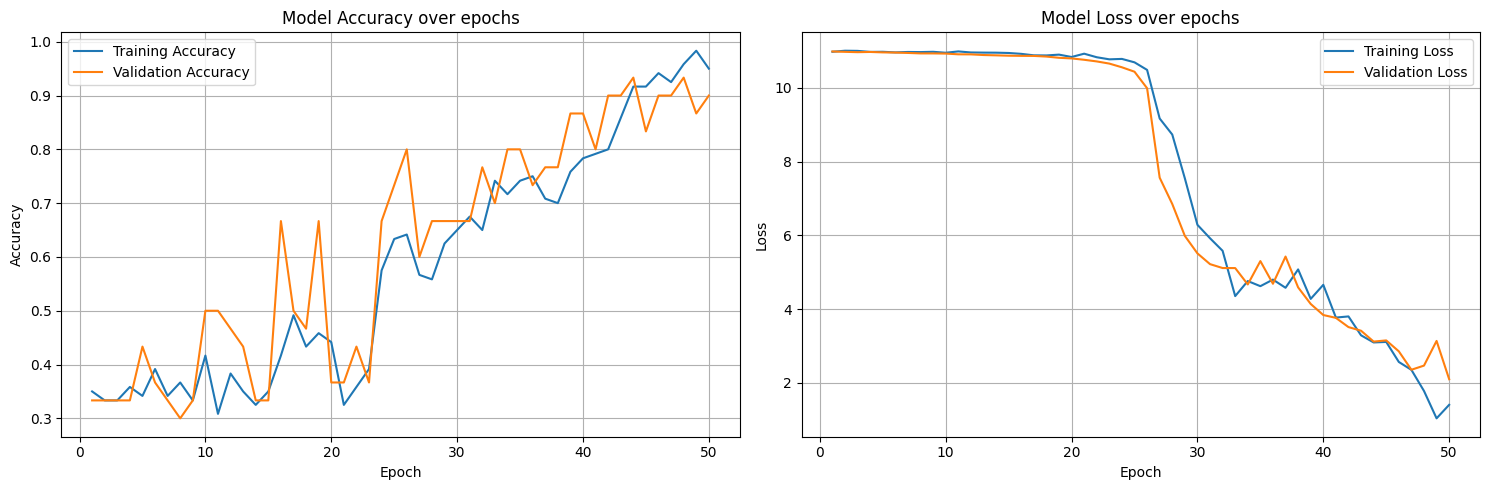

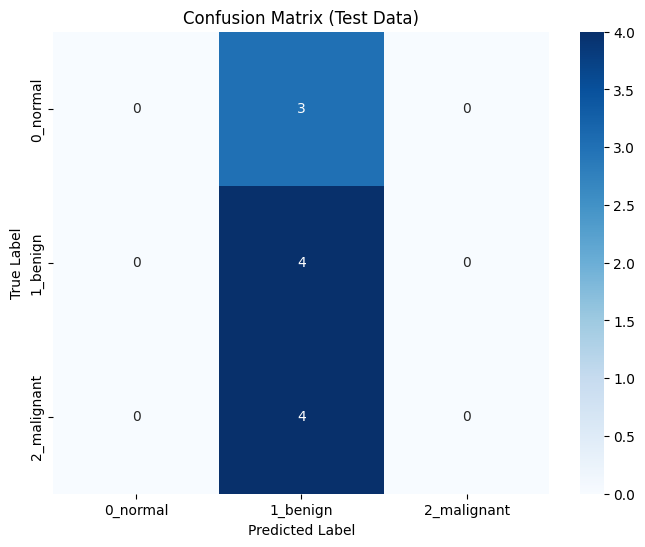


DONEEEEE.


In [ ]:
if __name__ == "__main__":
    print(f"Using device: {device}")
    print(f"Images per bag: {BAG_SIZE}")

    train_transforms = get_train_transforms(resize_dim=IMG_RESIZE, crop_dim=IMG_CROP_SIZE)
    eval_transforms = get_eval_transforms(img_dim=IMG_CROP_SIZE) # Use final crop size

    print("Load the datasets...")

    full_train_dataset = ImageBagDataset(
    image_dir=TRAIN_IMGS_PATH,
    transform=train_transforms,
    bag_size=BAG_SIZE,
    balance_classes=True
    )

    test_dataset = ImageBagDataset(
    image_dir=TEST_IMGS_PATH,
    transform=eval_transforms,
    bag_size=BAG_SIZE
    )

    print(f"Full Train dataset: {len(full_train_dataset)} bags found.")
    print(f"Test dataset: {len(test_dataset)} bags found.")

    # Train/Validation Split
    print("Splitting train data")
    targets = full_train_dataset.targets

    train_idx, val_idx = train_test_split(
        np.arange(len(targets)),
        test_size=0.2, # 20% for validation
        stratify=targets,
        random_state=RANDOM_SEED
    )

    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Weighted sampler for the training subset
    train_targets = np.array(targets)[train_idx]
    class_counts = np.bincount(train_targets, minlength=NUM_CLASSES)

    weights = 1.0 / class_counts #what if a class has no samples in the split

    sample_weights = np.array([weights[label] for label in train_targets])
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    print(f"Training subset size: {len(train_subset)}")
    print(f"Validation subset size: {len(val_subset)}")


    print("Creating DataLoaders...")
    num_workers = 2              # If there's issues set num_workers=0

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

    # creating model instance
    print(f"Setting up model with {BACKBONE_NAME} backbone")
    model = AttentionMILModel(num_classes=NUM_CLASSES, backbone_name=BACKBONE_NAME,
                      pretrained=PRETRAINED, feature_dim=FEATURE_DIM_L,
                      attention_dim=ATTENTION_DIM_D, attention_heads=ATTENTION_HEADS_K,
                      dropout=DROPOUT_RATE).to(device)


    class_weights_tensor = torch.tensor(CLASS_WEIGHTS, device=device, dtype=torch.float)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print(f"Using CrossEntropyLoss with weights: {CLASS_WEIGHTS}")


    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1) # Example scheduler

    # train model
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=device,
        save_dir=SAVE_MODEL_DIR,
        model_name='vam_model3.pth',
        patience=PATIENCE
        # Pass scheduler if using one
    )

    # Final Evaluation on Test Set
    print("\nEvaluating on Test Set")
    trained_model.to(device)
    test_metrics, all_labels, all_preds = evaluate_model(trained_model, test_loader, criterion, device)
    cmatrix = confusion_matrix(all_labels, all_preds)


    print("\nTest Set Evaluation Metrics")
    print(f"Test Loss: {test_metrics['loss']:.4f}")
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test Precision (Macro): {test_metrics['precision']:.4f}")
    print(f"Test Recall (Macro): {test_metrics['recall']:.4f}")
    print(f"Test F1 Score (Macro): {test_metrics['f1']:.4f}")
    print("Confusion Matrix:")
    print(cmatrix)
    print("")

    print("\nEvaluation per class")
    print(classification_report(all_labels, all_preds, target_names=["Normal", "Benign", "Malignant"]))


    # --- Plotting ---
    print("\nPlotting results")
    plot_training_history(history['train_loss'], history['train_acc'],
                          history['val_loss'], history['val_acc'])

    #Confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names=CLASS_NAMES)

    print("\nDONEEEEE.")

In [ ]:
BACKBONE_NAME = "vgg16"
PRETRAINED = "true"

Using device: cuda
Images per bag: 10
Load the datasets...
Full Train dataset: 150 bags found.
Test dataset: 11 bags found.
Splitting train data
Training subset size: 120
Validation subset size: 30
Creating DataLoaders...
Setting up model with vgg16 backbone


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 225MB/s]


Using CrossEntropyLoss with weights: [0.8, 0.6, 3.0]
Training started...
Epoch 1/50 | Train Loss: 10.9988, Acc: 0.3333 | Val Loss: 10.9236, Acc: 0.5333
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/vam_model4.pth
Epoch 2/50 | Train Loss: 10.7871, Acc: 0.4750 | Val Loss: 10.3294, Acc: 0.4667
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/vam_model4.pth
Epoch 3/50 | Train Loss: 7.8557, Acc: 0.6417 | Val Loss: 4.7993, Acc: 0.8333
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/vam_model4.pth
Epoch 4/50 | Train Loss: 4.9865, Acc: 0.7583 | Val Loss: 3.5574, Acc: 0.9000
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/vam_model4.pth
Epoch 5/50 | Train Loss: 3.8918, Acc: 0.8250 | Val Loss: 2.9459, Acc: 0.8667
Validation loss improved. Model saved to /content/drive/MyDrive/GBCUD/vam_model4.pth
Epoch 6/50 | Train Loss: 3.5724, Acc: 0.8750 | Val Loss: 2.4539, Acc: 0.9000
Validation loss improved. Model save

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


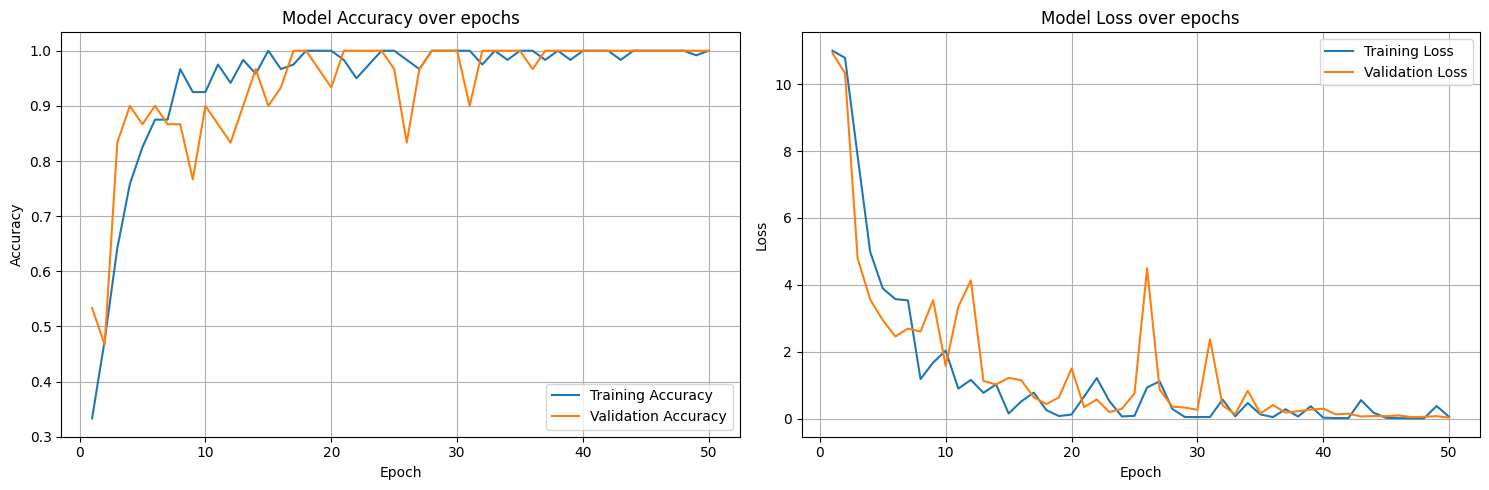

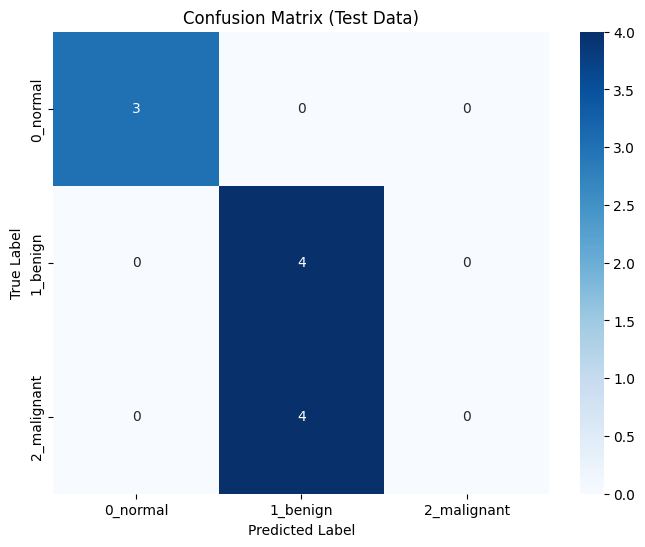


DONEEEEE.


In [ ]:
if __name__ == "__main__":
    print(f"Using device: {device}")
    print(f"Images per bag: {BAG_SIZE}")

    train_transforms = get_train_transforms(resize_dim=IMG_RESIZE, crop_dim=IMG_CROP_SIZE)
    eval_transforms = get_eval_transforms(img_dim=IMG_CROP_SIZE) # Use final crop size

    print("Load the datasets...")

    full_train_dataset = ImageBagDataset(
    image_dir=TRAIN_IMGS_PATH,
    transform=train_transforms,
    bag_size=BAG_SIZE,
    balance_classes=True
    )

    test_dataset = ImageBagDataset(
    image_dir=TEST_IMGS_PATH,
    transform=eval_transforms,
    bag_size=BAG_SIZE
    )

    print(f"Full Train dataset: {len(full_train_dataset)} bags found.")
    print(f"Test dataset: {len(test_dataset)} bags found.")

    # Train/Validation Split
    print("Splitting train data")
    targets = full_train_dataset.targets

    train_idx, val_idx = train_test_split(
        np.arange(len(targets)),
        test_size=0.2, # 20% for validation
        stratify=targets,
        random_state=RANDOM_SEED
    )

    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Weighted sampler for the training subset
    train_targets = np.array(targets)[train_idx]
    class_counts = np.bincount(train_targets, minlength=NUM_CLASSES)

    weights = 1.0 / class_counts #what if a class has no samples in the split

    sample_weights = np.array([weights[label] for label in train_targets])
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    print(f"Training subset size: {len(train_subset)}")
    print(f"Validation subset size: {len(val_subset)}")


    print("Creating DataLoaders...")
    num_workers = 2              # If there's issues set num_workers=0

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True)

    # creating model instance
    print(f"Setting up model with {BACKBONE_NAME} backbone")
    model = AttentionMILModel(num_classes=NUM_CLASSES, backbone_name=BACKBONE_NAME,
                      pretrained=PRETRAINED, feature_dim=FEATURE_DIM_L,
                      attention_dim=ATTENTION_DIM_D, attention_heads=ATTENTION_HEADS_K,
                      dropout=DROPOUT_RATE).to(device)


    class_weights_tensor = torch.tensor(CLASS_WEIGHTS, device=device, dtype=torch.float)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print(f"Using CrossEntropyLoss with weights: {CLASS_WEIGHTS}")


    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1) # Example scheduler

    # train model
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=device,
        save_dir=SAVE_MODEL_DIR,
        model_name='vam_model4.pth',
        patience=PATIENCE
        # Pass scheduler if using one
    )

    # Final Evaluation on Test Set
    print("\nEvaluating on Test Set")
    trained_model.to(device)
    test_metrics, all_labels, all_preds = evaluate_model(trained_model, test_loader, criterion, device)
    cmatrix = confusion_matrix(all_labels, all_preds)

    print("\nTest Set Evaluation Metrics")
    print(f"Test Loss: {test_metrics['loss']:.4f}")
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test Precision (Macro): {test_metrics['precision']:.4f}")
    print(f"Test Recall (Macro): {test_metrics['recall']:.4f}")
    print(f"Test F1 Score (Macro): {test_metrics['f1']:.4f}")
    print("Confusion Matrix:")
    print(cmatrix)
    print("")

    print("\nEvaluation per class")
    print(classification_report(all_labels, all_preds, target_names=["Normal", "Benign", "Malignant"]))


    # --- Plotting ---
    print("\nPlotting results")
    plot_training_history(history['train_loss'], history['train_acc'],
                          history['val_loss'], history['val_acc'])

    #Confusion matrix
    plot_confusion_matrix(all_labels, all_preds, class_names=CLASS_NAMES)

    print("\nDONEEEEE.")

In [ ]:
from collections import Counter
print("Test set distribution:", Counter(test_dataset.targets))


Test set distribution: Counter({np.int64(1): 4, np.int64(2): 4, np.int64(0): 3})


In [ ]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def visualize_attention_for_bag(model, bag_tensor, class_name="Unknown", show_images=True):
    model.eval()
    attention_scores = model.get_attention_map(bag_tensor)  # Returns [N]

    print(f"🔍 Attention scores for {class_name} bag:")
    for i, score in enumerate(attention_scores):
        print(f"Instance {i}: {score:.4f}")

    # Plot attention scores
    plt.figure(figsize=(10, 3))
    plt.plot(attention_scores, marker="o")
    plt.title(f"Attention Scores across Bag Instances ({class_name})")
    plt.xlabel("Instance Index")
    plt.ylabel("Attention Weight")
    plt.grid(True)
    plt.show()

    # Optional: visualize images sorted by attention
    if show_images:
        sorted_indices = sorted(range(len(attention_scores)), key=lambda i: -attention_scores[i])
        print("🖼️ Top images by attention:")

        num_top = min(5, len(sorted_indices))
        plt.figure(figsize=(15, 3))
        for idx, i in enumerate(sorted_indices[:num_top]):
            plt.subplot(1, num_top, idx + 1)
            img = bag_tensor[i].cpu()
            plt.imshow(to_pil_image(img))
            plt.title(f"Score: {attention_scores[i]:.2f}")
            plt.axis("off")
        plt.tight_layout()
        plt.show()
        print(f"Attention score range: {min(attention_scores):.2f} to {max(attention_scores):.2f}")


🔍 Attention scores for 2_malignant bag:
Instance 0: 0.2003
Instance 1: 0.1424
Instance 2: 0.1076
Instance 3: 0.0973
Instance 4: 0.0796
Instance 5: 0.0599
Instance 6: 0.0609
Instance 7: 0.1424
Instance 8: 0.0530
Instance 9: 0.0567


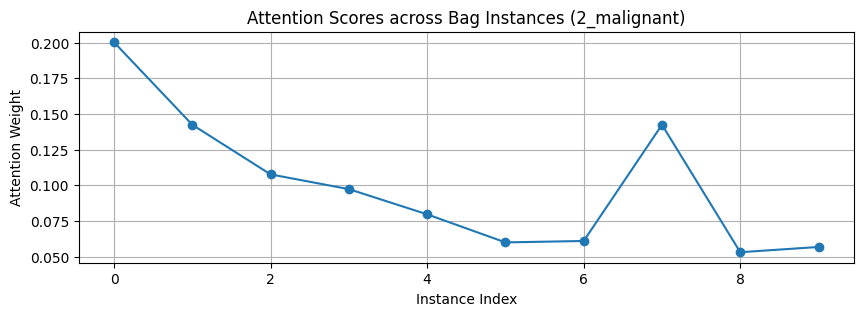

🖼️ Top images by attention:


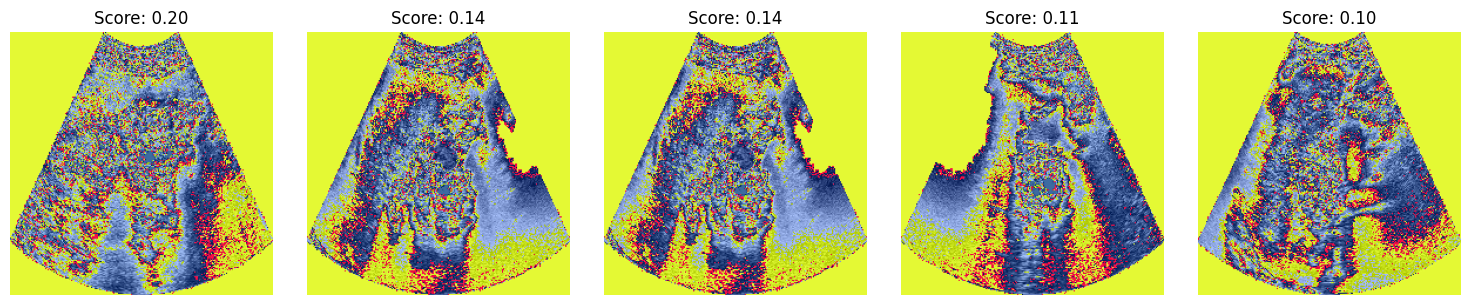

Attention score range: 0.05 to 0.20


In [ ]:
# Pick a test bag from the DataLoader or dataset
test_bag_tensor, label = test_dataset[2]  # Shape: [N, C, H, W]
visualize_attention_for_bag(model, test_bag_tensor, class_name=CLASS_NAMES[label])
